# 1 Preparing

In [9]:
import os
from gensim import models
import pandas as pd

In [111]:
import nltk
from nltk.corpus import stopwords
from string import punctuation

In [176]:
from gensim.models import KeyedVectors
import numpy as np

In [148]:
dataset_files = {}
dictionary_files = {}

# Target dataset (which is used for the true classification)
key_dataset = "coffee.xlsx"
dict_name = 'coffee_dict.xlsx'

# *** Datasets ***
dataset_path = '/home/jupyter/work/resources/content/datasets/'
dict_path = '/home/jupyter/work/resources/content/dictionaries/'

# Dataset structure - used for the source datasets fields
req_str = 'text'

# 2 Load data

In [7]:
# *** Datasets loading***
for entry in os.listdir(dataset_path):
    if os.path.isfile(os.path.join(dataset_path, entry)):
        dataset_files[entry] = dataset_path + entry
        
# *** Loadingf of dictionaries with brands and support words ***
for entry in os.listdir(dataset_path):
    if os.path.isfile(os.path.join(dataset_path, entry)):
        dictionary_files[entry] = dataset_path + entry

In [16]:
# Define the positive dataset
positive_dataset = pd.read_excel(dataset_files[key_dataset], header=None, names=[req_str], engine='openpyxl')
positive_dataset['label'] = 1

# Define the negative dataset

cont_dataset = pd.DataFrame()

for key, value in dataset_files.items():
    if key != key_dataset:
        tmp = pd.read_excel(value, header=None, names=[req_str], engine='openpyxl')
        tmp['label'] = 0
        
        # Checking that your target dataset does not contain the fields from other sets
        positive_dataset.drop(positive_dataset[positive_dataset[req_str].isin(tmp[req_str])].index, inplace=True)
        
        # Add a new part to the negative dataset 
        cont_dataset = pd.concat([cont_dataset, tmp], sort=False)

cont_dataset = cont_dataset.sample(frac = 1).reset_index(drop=True)

# Let us define the train data set which we are going to use during our model fitting, 
# and the validation dataset for the following checking of the model.

# Train Dataset
df_train = pd.concat([
    positive_dataset[:(round(positive_dataset.shape[0]*0.75))],
    cont_dataset[:(round(cont_dataset.shape[0]*0.75))]
]).sample(frac = 1).reset_index(drop=True)

# Validation dataset
df_val = pd.concat([
    positive_dataset[(round(positive_dataset.shape[0]*0.75)):],
    cont_dataset[(round(cont_dataset.shape[0]*0.75)):]
]).sample(frac = 1).reset_index(drop=True)

# 3 Preprocess data analysing

In [98]:
print("------")
print("Basic statistics")
print("")
print("Train shape: ", df_train.shape)
print("Validation shape: ", df_val.shape)
true_label = (df_train.label.value_counts() / df_train.shape[0])[1]
false_label = (df_train.label.value_counts() / df_train.shape[0])[0]
print(f"Class distribution:\n True = {round(true_label*100, 2)}%,\n False = {round(false_label*100, 2)}%")
print("")
print("------")
print("Label basic statistics")
print("")
print(df_train['label'].value_counts())
print("")
print("------")
print("Text basic statistics")
print("")
print('Total unique reqests counts:', len(df_train[req_str].unique()))
print("Mean amount of words in sentences (train dataset): ", df_train[req_str].str.split().map(len).mean())
print("Mean chars amount in sentences (train dataset): ", df_train[req_str].str.len().mean())
print("Max amount of words in sentences (train dataset): ", df_train[req_str].str.split().map(len).max())
print("Max chars amount in sentences (train dataset): ", df_train[req_str].str.len().max())
print("Mean amount of words in sentences (validation dataset): ", df_val[req_str].str.split().map(len).mean())
print("Mean chars amount in sentences (validation dataset): ", df_val[req_str].str.len().mean())
print("Max amount of words in sentences (validation dataset): ", df_val[req_str].str.split().map(len).max())
print("Max chars amount in sentences (validation dataset): ", df_val[req_str].str.len().max())
print("")
print("------")

------
Basic statistics

Train shape:  (432878, 2)
Validation shape:  (144293, 2)
Class distribution:
 True = 1.29%,
 False = 98.71%

------
Label basic statistics

0    427287
1      5591
Name: label, dtype: int64

------
Text basic statistics

Total unique reqests counts: 432731
Mean amount of words in sentences (train dataset):  3.571847033113256
Mean chars amount in sentences (train dataset):  24.173413756300853
Max amount of words in sentences (train dataset):  16
Max chars amount in sentences (train dataset):  100
Mean amount of words in sentences (validation dataset):  3.569979139667205
Mean chars amount in sentences (validation dataset):  24.15932858835841
Max amount of words in sentences (validation dataset):  15
Max chars amount in sentences (validation dataset):  95

------


<AxesSubplot:title={'center':'Amount of words in sentences'}>

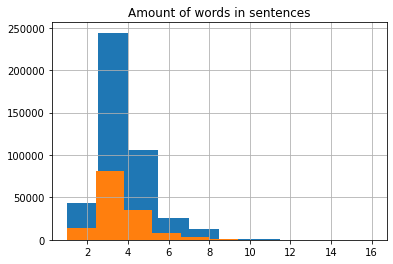

In [96]:
df_train[req_str].str.split().map(len).hist().set_title('Amount of words in sentences')
df_val[req_str].str.split().map(len).hist()

<AxesSubplot:title={'center':'Chars amount in sentences'}>

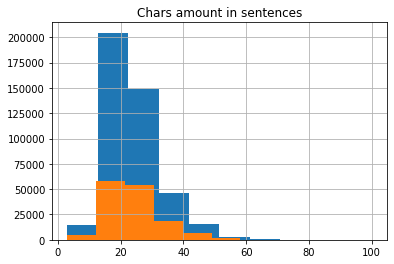

In [99]:
df_train[req_str].str.len().hist().set_title('Chars amount in sentences')
df_val[req_str].str.len().hist()

In [101]:
df_train.isnull().values.any(), df_val.isnull().values.any(),

(False, False)

# 4 Preprocess data

In [256]:
russian_stopwords = set(stopwords.words("russian"))

def preprocess_text(text):
    #tokens = mystem.lemmatize(text.lower())
    tokens = nltk.tokenize.word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

def preprocess_tokens(text):
    tokens = nltk.tokenize.word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    return tokens

df_train['tokens'] = df_train[req_str].apply(preprocess_tokens)
df_val['tokens'] = df_train[req_str].apply(preprocess_tokens)
df_train['cleaned_text'] = df_train[req_str].apply(preprocess_text)
df_val['cleaned_text'] = df_val[req_str].apply(preprocess_text)

In [257]:
df_train

,text,label,cleaned_text,tokens
0,наборы фигурок миньоны,0,наборы фигурок миньоны,"[наборы, фигурок, миньоны]"
1,bandai megazord,0,bandai megazord,"[bandai, megazord]"
2,чайный домик ниндзяго,0,чайный домик ниндзяго,"[чайный, домик, ниндзяго]"
3,игрушки брудер мусоровоз цена,0,игрушки брудер мусоровоз цена,"[игрушки, брудер, мусоровоз, цена]"
4,кукла shibajuku girls купить интернет магазин,0,кукла shibajuku girls купить интернет магазин,"[кукла, shibajuku, girls, купить, интернет, ма..."
...,...,...,...,...
432873,электронные игры для девочек холодное сердце,0,электронные игры девочек холодное сердце,"[электронные, игры, девочек, холодное, сердце]"
432874,паровозик для детей игрушка купить,0,паровозик детей игрушка купить,"[паровозик, детей, игрушка, купить]"
432875,памперсы кораблик цена,0,памперсы кораблик цена,"[памперсы, кораблик, цена]"
432876,игрушка мазда демио,0,игрушка мазда демио,"[игрушка, мазда, демио]"


In [258]:
df_val

,text,label,cleaned_text,tokens
0,купить игрушечная мастерская,0,купить игрушечная мастерская,"[наборы, фигурок, миньоны]"
1,игрушка chericole,0,игрушка chericole,"[bandai, megazord]"
2,растения для акватеррариума,0,растения акватеррариума,"[чайный, домик, ниндзяго]"
3,kami l espresso oro,1,kami l espresso oro,"[игрушки, брудер, мусоровоз, цена]"
4,minecraft steve 1,0,minecraft steve 1,"[кукла, shibajuku, girls, купить, интернет, ма..."
...,...,...,...,...
144288,корм уценка уцененный срок кошек,0,корм уценка уцененный срок кошек,"[детский, набор, строительных, инструментов, м..."
144289,фиолетовая собака мультик,0,фиолетовая собака мультик,"[купить, динозавра, плео, москве]"
144290,интерактивный щенок гоша,0,интерактивный щенок гоша,"[закупка, памперсов, оптом, производителя]"
144291,набор техники военный,0,набор техники военный,"[кукла, пупс, danielle]"


In [147]:
def cnt_uniq(col):
    count = set()
    for line in col:
        count |= set(line)
    return len(count)

print("------")
print("Unique words in df_train.tokens: ", cnt_uniq(df_train.tokens))
print("Unique words in df_val.tokens: ", cnt_uniq(df_val.tokens))
print("------")

------
Unique words in df_train.tokens:  63541
Unique words in df_val.tokens:  36983
------


# 5 Taking pre-trained word2vec or fastText embeddings and vectorize the data

In [154]:
# https://rusvectores.org/ru/models/
# for the ferst approach let us take geowac_tokens_none_fasttextskipgram_300_5_2020
# http://vectors.nlpl.eu/repository/20/214.zip
%time
!wget -c 'http://vectors.nlpl.eu/repository/20/214.zip' --directory-prefix='content/models'

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10 µs
--2021-09-18 18:08:05--  http://vectors.nlpl.eu/repository/20/214.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [153]:
!unzip 'content/models/214.zip' -d 'content/models/214'

Archive:  content/models/214.zip
  inflating: content/models/214/meta.json  
  inflating: content/models/214/model.model  
  inflating: content/models/214/model.model.vectors_ngrams.npy  
  inflating: content/models/214/model.model.vectors.npy  
  inflating: content/models/214/model.model.vectors_vocab.npy  
  inflating: content/models/214/README  


In [168]:
w2v_model = KeyedVectors.load('content/models/214/model.model')

In [169]:
print(w2v_model.most_similar('teacher'))
# Output = [('headteacher', 0.8075869083404541), ('schoolteacher', 0.7955552339553833), ('teachers', 0.733420729637146), ('teaches', 0.6839243173599243), ('meacher', 0.6825737357139587), ('teach', 0.6285147070884705), ('taught', 0.6244685649871826), ('teaching', 0.6199781894683838), ('schoolmaster', 0.6037642955780029), ('lessons', 0.5812176465988159)]

print(w2v_model.similarity('teacher', 'teaches'))
# Output = 0.683924396754

[('teachers', 0.8642313480377197), ('teach', 0.8517892360687256), ('teaching', 0.804637610912323), ('preacher', 0.745186984539032), ('students', 0.7032978534698486), ('grammar', 0.6876246333122253), ('education', 0.6809180378913879), ('language', 0.6790481805801392), ('learning', 0.6770287752151489), ('lessons', 0.6763585805892944)]
0.86742723


# 6 Use pretrained embeddings as features to a classifier

In [298]:
def avg_feature_vector(sentence, model, num_features):
    words = sentence.split()
    feature_vec = np.zeros((num_features,),dtype="float32")
    i=0
    for word in words:
        try:
            feature_vec = np.add(feature_vec, model[word])
        except KeyError as error:
            feature_vec 
            i = i + 1
    if len(words) > 0:
        feature_vec = np.divide(feature_vec, len(words)- i)
    return feature_vec

In [299]:
#!g1.1
x_train = pd.DataFrame()
word2vec_train = np.zeros((len(df_train.index), 300),dtype="float32")

for i in range(len(df_train.index)):
    word2vec_train[i] = avg_feature_vector(df_train["cleaned_text"][i], w2v_model, 300)

names_df = pd.DataFrame(data=word2vec_train)
x_train = pd.concat([x_train, names_df], axis=1)
y_train = df_train.label
x_train

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.066713,0.082942,-0.010662,-0.111803,-0.079457,-0.434792,-0.106997,0.365572,-0.149611,-0.018134,...,-0.069665,0.188845,-0.223124,0.251621,0.090919,0.059522,0.032352,-0.067513,0.058853,-0.065847
1,-0.261288,-0.060402,0.342453,-0.311789,0.115866,-0.059775,-0.135599,0.022243,0.199407,0.170820,...,0.032028,-0.023515,0.024769,0.278460,-0.016381,0.322340,-0.243902,-0.020962,-0.312346,-0.036781
2,0.038728,0.003996,-0.049787,0.024954,-0.254933,-0.251597,-0.116762,0.250436,-0.207230,0.167426,...,0.023190,-0.174606,0.019169,0.063979,0.055845,-0.007685,0.137719,0.047505,0.051777,-0.226418
3,-0.124907,-0.087466,-0.043224,-0.055114,-0.036133,-0.206226,-0.301870,0.167975,0.116403,0.245811,...,-0.101062,0.115150,-0.111792,0.020151,0.151601,0.222682,0.039344,-0.133292,-0.055217,-0.013471
4,-0.262756,-0.041589,0.175519,0.002730,-0.240115,-0.319160,-0.015173,0.225068,-0.110758,0.231244,...,-0.034381,-0.000137,-0.016929,0.117933,0.150310,0.066467,-0.107601,-0.088795,-0.293791,0.092952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432873,-0.144212,0.002015,0.129216,-0.152031,-0.172071,-0.294749,-0.044193,0.181058,0.197308,0.142886,...,0.029808,-0.065910,-0.049157,0.030863,-0.069495,-0.054453,0.180123,-0.051211,-0.154920,-0.075380
432874,-0.069521,0.000091,-0.022347,-0.030287,-0.292700,-0.220955,-0.120907,0.198400,0.074411,0.084859,...,-0.050527,0.178038,0.044302,0.031576,0.018763,0.211343,0.130179,-0.100829,-0.048994,-0.099164
432875,0.027515,-0.208212,0.069029,0.103831,-0.262487,-0.219450,-0.121879,0.072449,-0.045080,0.267747,...,0.084002,0.098646,-0.044730,-0.046645,0.323528,0.439951,0.058484,-0.044691,-0.102957,0.039338
432876,-0.100114,0.194142,0.168734,-0.223016,-0.136961,-0.139871,-0.238558,0.264664,0.010691,0.230914,...,-0.444528,0.055486,-0.071525,0.176366,-0.055109,0.287983,0.074734,-0.249084,-0.217787,-0.182936


In [300]:
#!g1.1
x_val = pd.DataFrame()
word2vec_val = np.zeros((len(df_val.index), 300),dtype="float32")

for i in range(len(df_val.index)):
    word2vec_val[i] = avg_feature_vector(df_val["cleaned_text"][i], w2v_model, 300)

names_df = pd.DataFrame(data=word2vec_val)
x_val = pd.concat([x_val, names_df], axis=1)
y_val = df_val.label
x_val

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.215482,0.056077,0.215897,-0.039115,-0.250837,-0.415031,-0.101325,0.310755,0.042518,0.117582,...,0.040898,0.089389,-0.038331,0.134966,0.125776,0.047613,0.118618,-0.082383,-0.142240,-0.050848
1,-0.279157,-0.057534,0.076047,-0.177353,0.113635,-0.216639,0.000805,0.340235,-0.226799,0.153182,...,-0.226059,0.021316,0.165585,0.079438,0.025206,0.240427,-0.124433,-0.023450,-0.128410,-0.236934
2,-0.160039,0.252769,0.195136,0.229320,-0.405540,-0.110455,-0.073409,0.411702,-0.270468,0.188854,...,0.238225,-0.231371,0.171309,0.204717,-0.140009,0.122218,0.293683,-0.191857,0.037476,-0.227324
3,-0.453910,-0.089990,0.237365,-0.084725,-0.169180,-0.238084,0.099591,0.187045,0.016369,0.223402,...,-0.358097,-0.046825,0.253699,0.211709,0.026575,0.140188,-0.088641,-0.011999,-0.219470,-0.020468
4,-0.048142,0.044558,0.000380,-0.095190,0.029367,-0.226655,0.159691,0.197191,0.007566,-0.078022,...,-0.282879,-0.082614,-0.037469,0.197718,0.271753,0.094493,0.132802,-0.101094,-0.163882,-0.076224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144288,-0.339769,-0.107381,0.009420,0.045568,-0.118220,-0.078068,-0.028155,0.179262,-0.125040,0.049011,...,-0.081069,-0.059478,0.306995,0.275422,-0.285694,0.060659,0.162306,-0.075434,-0.044172,0.043803
144289,-0.293207,-0.095126,-0.027711,-0.098639,-0.409341,-0.207911,0.046775,0.423479,-0.186880,0.062058,...,-0.035500,0.087183,0.009583,0.109173,0.105867,0.171229,0.076693,0.062442,0.101581,-0.254318
144290,0.082674,0.141088,-0.100725,0.057958,-0.141860,-0.138624,0.151382,0.257522,-0.072118,0.236993,...,-0.241572,-0.057554,0.245067,0.071724,-0.168804,0.109397,-0.016880,-0.108166,-0.128291,-0.122228
144291,-0.259409,0.091483,0.181957,0.074490,-0.042760,-0.090822,0.177005,0.152788,-0.034932,0.133722,...,-0.350604,0.153736,-0.099569,0.041787,-0.027424,-0.122549,0.268015,-0.116131,-0.194821,0.118828


In [193]:
#!g1.1
#from tqdm import tqdm
# https://github.com/tqdm/tqdm
from sklearn.ensemble import RandomForestClassifier
#rfc = RandomForestClassifier(n_estimators=300, random_state=5)
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [197]:
#!g1.1
import pickle
# Save the model
model_src = 'content/models/random_forest_classifier.pickle'

pickle.dump(rfc, open(model_src, 'wb'))

In [301]:
#!g1.1
from sklearn.linear_model import SGDClassifier

#model_sgd = SGDClassifier(class_weight={1:.99})
model_sgd = SGDClassifier(
    random_state=None,
    class_weight=None,
    loss='perceptron', 
    penalty='l2'
)
model_sgd.fit(x_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='perceptron',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

# 7 Check the classifier 

In [302]:
def chk_classifier(prediction, validation):

    print("*** Check and calculate the metrics ourselves ***")

    # model prediction result
    a_check = prediction
    # Validation resuls  
    b_check = np.array(validation)
    # проверим размерность
    print("Check shapes of the prediction and Y validation:", a_check.shape, b_check.shape)

    # True Negative Predicted - false, Real - false
    ab_diff_tn = []
    # False Negative Predicted - false, Real - True
    ab_diff_fn = []
    # False positive Predicted - True, Real - False
    ab_diff_fp = []
    # True positive Predicted - True, Real - True
    ab_diff_tp = []

    print('')
    print('******')

    for indx in range(len(a_check)):
        if (a_check[indx] == True):
            if (b_check[indx] == True):
                ab_diff_tp.append(indx)
            else:
                ab_diff_fp.append(indx)
        else:
            if (b_check[indx] == True):
                ab_diff_fn.append(indx)
            else:
                ab_diff_tn.append(indx)

    tn =  len(ab_diff_tn)
    fn =  len(ab_diff_fn)
    fp =  len(ab_diff_fp)
    tp =  len(ab_diff_tp)

    print(f"True Negative:  {tn}  | False Positive:  {fp}")
    print(f"False Negative: {fn}   | True Positive:  {tp}")

    print(f"Precision = {tp} / ( {tp} + {fp} ) = {round(tp/(tp+fp), 2)}")
    print(f"Recall = {tp} / ( {tp} + {fn} ) = {round(tp/(tp+fn), 2) }")

    print('')
    print('******')
    print(f"Accurracy = {round(metrics.accuracy_score(a_check, b_check), 2) }")
    print(f"F1 Score = {round(metrics.f1_score(a_check, b_check, average='weighted'), 2) }")
    

In [303]:
print("*** Check the model by the validation data ***")

predicted_sgd = model_sgd.predict(x_val)
print(metrics.classification_report(predicted_sgd, y_val))

*** Check the model by the validation data ***
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    142478
           1       0.93      0.96      0.94      1815

    accuracy                           1.00    144293
   macro avg       0.97      0.98      0.97    144293
weighted avg       1.00      1.00      1.00    144293



In [304]:
from sklearn.metrics import accuracy_score
accuracy_score(predicted_sgd, y_val)

0.9985654189738934

In [305]:
chk_classifier(predicted_sgd.view(), y_val)

*** Check and calculate the metrics ourselves ***
Check shapes of the prediction and Y validation: (144293,) (144293,)

******
True Negative:  142350  | False Positive:  79
False Negative: 128   | True Positive:  1736
Precision = 1736 / ( 1736 + 79 ) = 0.96
Recall = 1736 / ( 1736 + 128 ) = 0.93

******
Accurracy = 1.0
F1 Score = 1.0


# 8 BERT-like models

In [ ]:
#!g1.1
# https://huggingface.co/DeepPavlov/rubert-base-cased

# from transformers import AutoTokenizer, AutoModel
  
# tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

# model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

# import transformers
# from transformers import AutoTokenizer, AutoModel

# # Load the BERT tokenizer.
# print('Loading BERT tokenizer...')
# #tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)
# tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [306]:
#!g1.1
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-32GB


In [336]:
#!g1.1
import transformers
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
#tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

Loading BERT tokenizer...


In [337]:
#!g1.1

sentences = df_train.cleaned_text.values
labels = df_train.label.values

# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  наборы фигурок миньоны
Tokenized:  ['наборы', 'фигурок', 'мин', '##ьон', '##ы']
Token IDs:  [74470, 105592, 6186, 45898, 880]


In [338]:
#!g1.1
sentences = "Our friends won't buy this analysis, let alone the next one we propose."

# Print the original sentence.
print(' Original: ', sentences)

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences)))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'fri', '##ends', 'wo', '##n', "'", 't', 'bu', '##y', 'this', 'anal', '##ysis', ',', 'let', 'al', '##one', 'the', 'ne', '##xt', 'one', 'we', 'prop', '##ose', '.']
Token IDs:  [17958, 35862, 50842, 13308, 259, 118, 270, 12011, 281, 11043, 107127, 66861, 128, 14107, 10676, 13438, 10617, 11066, 29395, 10976, 12463, 30557, 15081, 132]


In [339]:
# #!g1.1
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# # from transformers import AutoModelForSequenceClassification
# from transformers import BertTokenizerFast

# #tokenizer = AutoTokenizer.from_pretrained("IlyaGusev/xlm_roberta_large_headline_cause_full")
# tokenizer = AutoTokenizer.from_pretrained("IlyaGusev/xlm_roberta_large_headline_cause_full")
# # tokenizer = BertTokenizerFast.from_pretrained('blanchefort/rubert-base-cased-sentiment')
# #tokenizer = BertTokenizerFast.from_pretrained('blanchefort/rubert-base-cased-sentiment')

In [ ]:
#!g1.1


In [ ]:
#!g1.1


In [ ]:
#!g1.1


In [ ]:
#!g1.1


In [ ]:
#!g1.1
